#Final Code

## Imports and Loading in Data

In [ ]:
! pip install pyspark -q

In [ ]:
# imports
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark import SparkContext
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, VectorIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as f, Row
from pyspark.ml import feature, clustering, Pipeline
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType, FloatType
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.sql.functions import when, col
from pyspark.ml.feature import Bucketizer, PCA
from pyspark.ml import feature, evaluation, Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.classification import GBTClassifier
from pyspark.sql.functions import avg

In [ ]:
# loading in data
data2023 = "/content/AB_US_2023.csv"


In [ ]:
# creating a spark session
spark = SparkSession.builder \
    .appName("CSV to DataFrame") \
    .getOrCreate()

## Loading in Data

In [ ]:
# manually setting schema
schema = StructType([
    StructField("id", StringType(), True),
    StructField("name", StringType(), True),
    StructField("host_id", StringType(), True),
    StructField("host_name", StringType(), True),
    StructField("neighbourhood_group", StringType(), True),
    StructField("neighbourhood", StringType(), True),
    StructField("latitude", DoubleType(), True),
    StructField("longitude", DoubleType(), True),
    StructField("room_type", StringType(), True),
    StructField("minimum_nights", IntegerType(), True),
    StructField("number_of_reviews", IntegerType(), True),
    StructField("last_review", DoubleType(), True),
    StructField("reviews_per_month", DateType(), True),
    StructField("calculated_host_listings_count", DoubleType(), True),
    StructField("availability_365", IntegerType(), True),
    StructField("price", DoubleType(), True),
    StructField("number_of_reviews_ltm", IntegerType(), True),
    StructField("city", StringType(), True)

])

In [ ]:
# reading data to spark csv
data = spark.read.csv(data2023, header=True, schema=schema)

In [ ]:
# reading in data for visualizations
vis_data = pd.read_csv(data2023, low_memory=False)


## Visuals

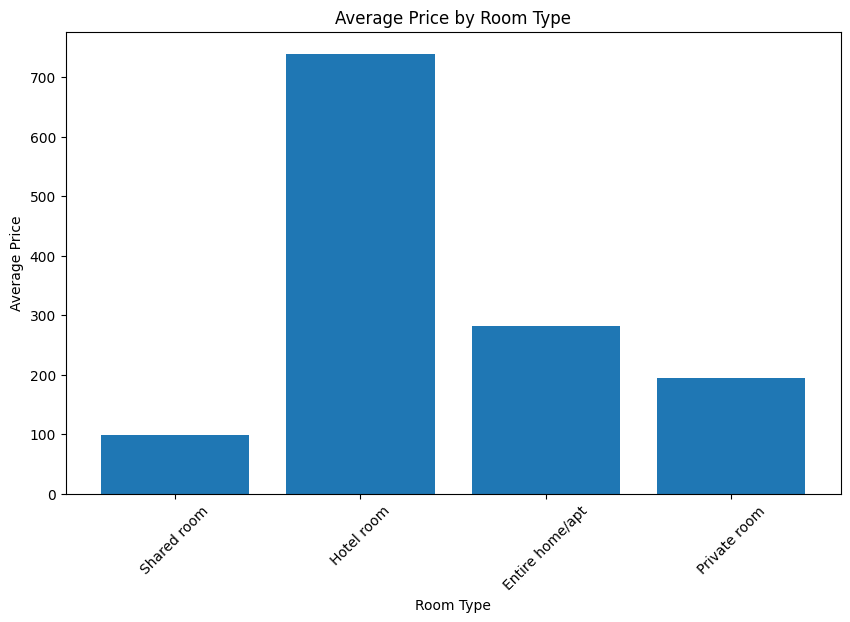

In [ ]:
spark_df = spark.createDataFrame(vis_data)

# Calculate average price by room type
avg_price_by_room_type = spark_df.groupBy('room_type').agg(avg('price').alias('avg_price'))

# Convert to Pandas DataFrame for plotting
result_df = avg_price_by_room_type.toPandas()


plt.figure(figsize=(10, 6))
plt.bar(result_df['room_type'], result_df['avg_price'])
plt.title('Average Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

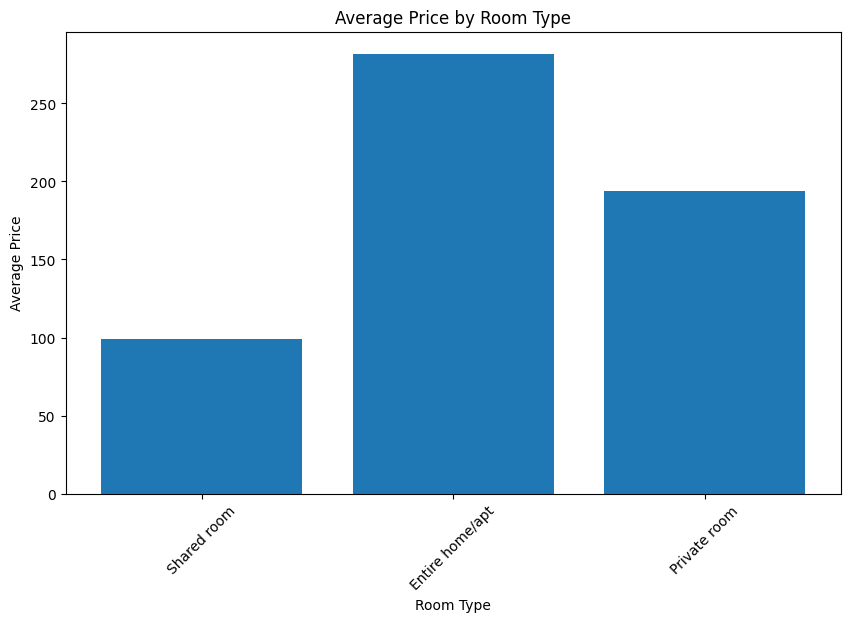

In [ ]:

# Calculate average price by room type
avg_price_by_room_type = spark_df.groupBy('room_type').agg(avg('price').alias('avg_price'))

# Filter to include only room types with average price <= 309
filtered_avg_price_by_room_type = avg_price_by_room_type.filter(avg_price_by_room_type['avg_price'] <= 309)

# Convert to Pandas DataFrame for plotting
result_df = filtered_avg_price_by_room_type.toPandas()

# Plotting with Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(result_df['room_type'], result_df['avg_price'])
plt.title('Average Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

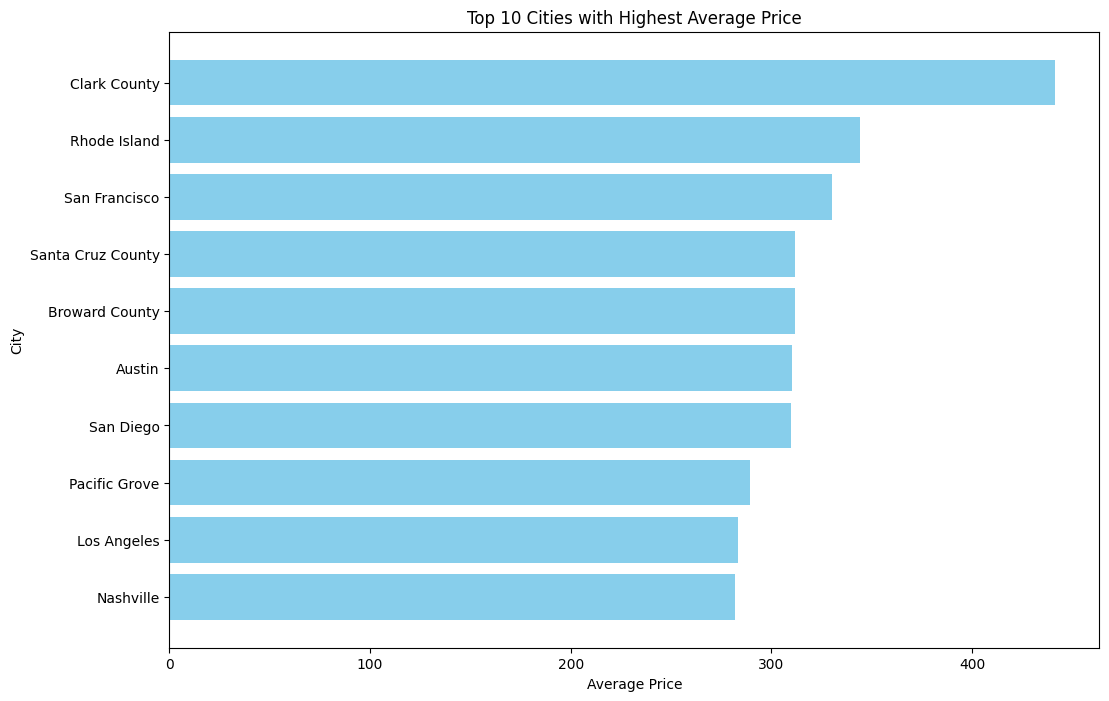

In [ ]:
# Calculate average price by city
avg_price_by_city = spark_df.groupBy('city').agg(avg('price').alias('avg_price'))

# Order by avg_price in descending order to find the highest average priced cities
highest_avg_price_cities = avg_price_by_city.orderBy('avg_price', ascending=False).limit(10)

# Convert to Pandas DataFrame for plotting
highest_avg_price_cities_df = highest_avg_price_cities.toPandas()

# Plotting with Matplotlib
plt.figure(figsize=(12, 8))
plt.barh(highest_avg_price_cities_df['city'], highest_avg_price_cities_df['avg_price'], color='skyblue')
plt.title('Top 10 Cities with Highest Average Price')
plt.xlabel('Average Price')
plt.ylabel('City')
plt.gca().invert_yaxis()  # Invert y-axis to display highest price at the top
plt.show()

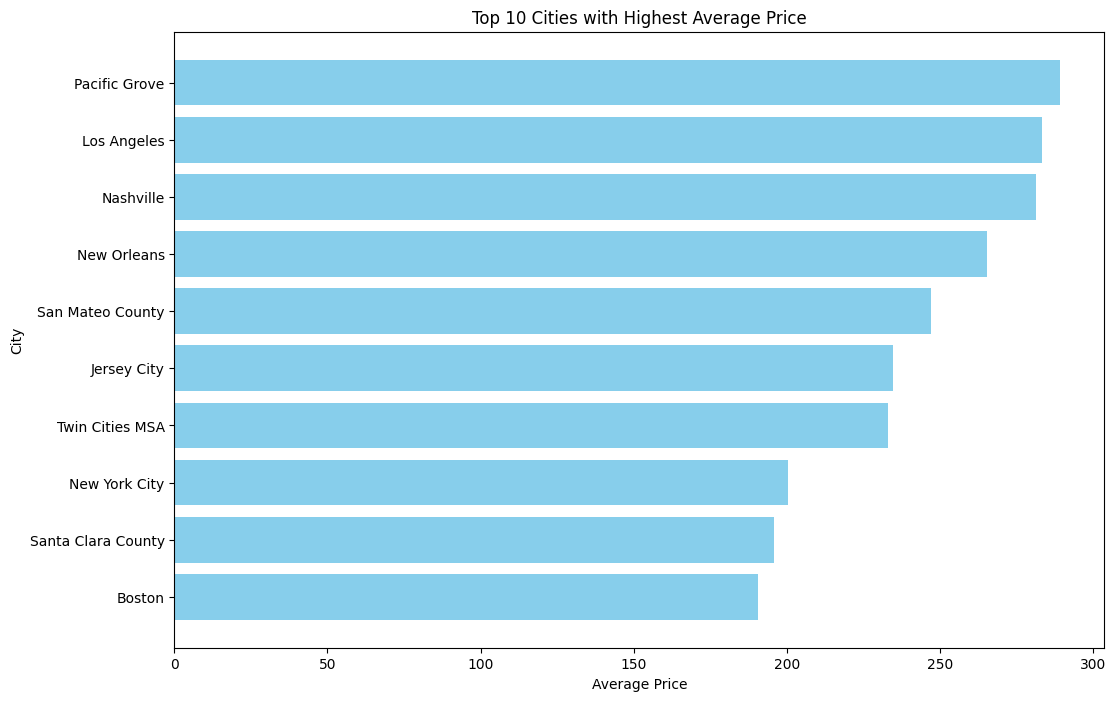

In [ ]:
# Calculate average price by city
avg_price_by_city = spark_df.groupBy('city').agg(avg('price').alias('avg_price'))

# Filter to include only cities where average price <= 309
filtered_avg_price_by_city = avg_price_by_city.filter(avg_price_by_city['avg_price'] <= 309)

# Order by avg_price in descending order to find the highest average priced cities
highest_avg_price_cities = filtered_avg_price_by_city.orderBy('avg_price', ascending=False).limit(10)

# Convert to Pandas DataFrame for plotting
highest_avg_price_cities_df = highest_avg_price_cities.toPandas()

# Plotting with Matplotlib
plt.figure(figsize=(12, 8))
plt.barh(highest_avg_price_cities_df['city'], highest_avg_price_cities_df['avg_price'], color='skyblue')
plt.title('Top 10 Cities with Highest Average Price')
plt.xlabel('Average Price')
plt.ylabel('City')
plt.gca().invert_yaxis()  # Invert y-axis to display highest price at the top
plt.show()

##Preprocessing

In [ ]:
# dropping unnessecary columns for models
cols_to_drop = ['id','host_id','host_name','longitude','latitude','name']
data2 = data.drop(*cols_to_drop)

In [ ]:
# filling the neighourhood_group NULLs since its an important column
data3 = data2.na.fill({'neighbourhood_group': 'Unknown'})


In [ ]:
# dropping any row w/ NULLs
data3 = data3.dropna()

In [ ]:
# cutting price off at 309, dropping whole row
data3 = data3.filter(data.price <= 309)

In [ ]:
# binning values into quarters in order to improve model performance
columns = ['minimum_nights', 'number_of_reviews', 'last_review', 'calculated_host_listings_count', 'availability_365', 'price', 'number_of_reviews_ltm']

quartiles = {}
for col in columns:
    quartiles[col] = data3.approxQuantile(col, [0.25, 0.5, 0.75], 0.01)

def assign_quartile_bin(value, quartiles):
    if value <= quartiles[0]:
        return 1
    elif value <= quartiles[1]:
        return 2
    elif value <= quartiles[2]:
        return 3
    else:
        return 4

assign_quartile_bin_udf = F.udf(lambda value, quartiles: assign_quartile_bin(value, quartiles), IntegerType())

for col in columns:
    data3 = data3.withColumn(col+'_bin', assign_quartile_bin_udf(F.col(col), F.array([F.lit(q) for q in quartiles[col]])))


+-------------------+-------------------+---------------+--------------+-----------------+-----------+-----------------+------------------------------+----------------+-----+---------------------+-------------+------------------+---------------------+---------------+----------------------------------+--------------------+---------+-------------------------+
|neighbourhood_group|      neighbourhood|      room_type|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|price|number_of_reviews_ltm|         city|minimum_nights_bin|number_of_reviews_bin|last_review_bin|calculated_host_listings_count_bin|availability_365_bin|price_bin|number_of_reviews_ltm_bin|
+-------------------+-------------------+---------------+--------------+-----------------+-----------+-----------------+------------------------------+----------------+-----+---------------------+-------------+------------------+---------------------+---------------+-------------

In [ ]:
data3.printSchema()

root
 |-- neighbourhood_group: string (nullable = false)
 |-- neighbourhood: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- last_review: double (nullable = true)
 |-- reviews_per_month: date (nullable = true)
 |-- calculated_host_listings_count: double (nullable = true)
 |-- availability_365: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- number_of_reviews_ltm: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- minimum_nights_bin: integer (nullable = true)
 |-- number_of_reviews_bin: integer (nullable = true)
 |-- last_review_bin: integer (nullable = true)
 |-- calculated_host_listings_count_bin: integer (nullable = true)
 |-- availability_365_bin: integer (nullable = true)
 |-- price_bin: integer (nullable = true)
 |-- number_of_reviews_ltm_bin: integer (nullable = true)



In [ ]:
# splitting price based on median
threshold = 209

data_binned = data3.withColumn('price_category', when(data3['price'] >= threshold, 1).otherwise(0))

In [ ]:
# one hot encoding city
city_indexer = StringIndexer(inputCol='city', outputCol='city_bin')
indexer_model_city = city_indexer.fit(data_binned)
data_indexed2 = indexer_model_city.transform(data_binned)

In [ ]:
# one hot encoding room_type
room_type_indexer = StringIndexer(inputCol='room_type', outputCol='room_type_bin')
indexer_model_room_type = room_type_indexer.fit(data_binned)
data_indexed2 = indexer_model_room_type.transform(data_indexed2)

In [ ]:
# one hot encoding neighbourhood
neighbourhood_indexer = StringIndexer(inputCol='neighbourhood', outputCol='neighbourhood_bin')
indexer_model_neighbourhood = neighbourhood_indexer.fit(data_binned)
data_indexed2 = indexer_model_neighbourhood.transform(data_indexed2)

In [ ]:
# one hot encoding neighbourhood_group
neighbourhood_group_indexer = StringIndexer(inputCol='neighbourhood_group', outputCol='neighbourhood_group_bin')
indexer_model_neighbourhood_group = neighbourhood_group_indexer.fit(data_binned)
data_indexed2 = indexer_model_neighbourhood_group.transform(data_indexed2)

In [ ]:
# checking final modelling df
data_indexed2.printSchema()

root
 |-- neighbourhood_group: string (nullable = false)
 |-- neighbourhood: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- last_review: double (nullable = true)
 |-- reviews_per_month: date (nullable = true)
 |-- calculated_host_listings_count: double (nullable = true)
 |-- availability_365: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- number_of_reviews_ltm: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- minimum_nights_bin: integer (nullable = true)
 |-- number_of_reviews_bin: integer (nullable = true)
 |-- last_review_bin: integer (nullable = true)
 |-- calculated_host_listings_count_bin: integer (nullable = true)
 |-- availability_365_bin: integer (nullable = true)
 |-- price_bin: integer (nullable = true)
 |-- number_of_reviews_ltm_bin: integer (nullable = true)
 |-- price_category: integer (nullable = false)
 |-- city_b

##Models

### Linear Regression

In [ ]:
# splitting data for linear regression
(train_data, test_data) = data_indexed2.randomSplit([0.7, 0.3], seed=42)
[train_data.count(), test_data.count()]

[95969, 41137]

In [ ]:
# creating linear pca pipeline
features = ['minimum_nights_bin','number_of_reviews_bin','last_review_bin','calculated_host_listings_count_bin','availability_365_bin','number_of_reviews_ltm_bin','neighbourhood_group_bin','neighbourhood_bin','room_type_bin','city_bin']

assembler = VectorAssembler(inputCols=features, outputCol="features")

pca = PCA(k=7, inputCol="features", outputCol="pcaFeatures")

linear_regression = LinearRegression(featuresCol="pcaFeatures", labelCol="price_category")

pipeline_li = Pipeline(stages=[assembler, pca, linear_regression])


In [ ]:
# linear pca model
model_li = pipeline_li.fit(train_data)

In [ ]:
# linear pca test
predictions_li = model_li.transform(test_data)


In [ ]:
#evaluating linear
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions_li)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 157.095


In [ ]:
# MSE linear
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions_li)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 24678.962497089447


In [ ]:
# Create the evaluator object for RMSE and R^2
rmse_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")

# Compute metrics
rmse = rmse_evaluator.evaluate(predictions_li)
r_squared = r2_evaluator.evaluate(predictions_li)

# Print the results
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 (Coefficient of Determination): {r_squared}")

Root Mean Squared Error (RMSE): 157.09539298492953
R^2 (Coefficient of Determination): -1.4602960569399124


### Logistic Regression

In [ ]:
# splitting data for logistic regression
(train_data2, test_data2) = data_indexed2.randomSplit([0.7, 0.3], seed=40)

In [ ]:
# creating pipeline
pca_lo = PCA(k=10, inputCol="features", outputCol="pcaFeatures")

logistic_regression = LogisticRegression(featuresCol="pcaFeatures", labelCol="price_category")

pipeline_lo = Pipeline(stages=[assembler, pca_lo, logistic_regression])


In [ ]:
# Fit model
model_lo = pipeline_lo.fit(train_data2)

In [ ]:
# Predict
predictions_lo = model_lo.transform(test_data2)

In [ ]:
# Evaluate
evaluator = BinaryClassificationEvaluator(labelCol="price_category", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions_lo)

print(f"Area Under ROC: {auc}")

Area Under ROC: 0.6524524371169955


### Gradient Boosting Trees

In [ ]:
# creating gbt pipeline
gbt = GBTClassifier(featuresCol='features', labelCol='price_category', maxBins=1500)

pipeline_gbt = Pipeline(stages=[assembler, gbt])

In [ ]:
#training for gbt
train_data3, test_data3 = data_indexed2.randomSplit([.7, .3], seed=40)


In [ ]:
# training model
model_gbt = pipeline_gbt.fit(train_data)


In [ ]:
# testing model
predictions_gbt = model_gbt.transform(test_data)


In [ ]:
# Finding accuracy, precision, recall, f1 for gbt
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="price_category", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator_accuracy.evaluate(predictions_gbt)
print("Accuracy:", accuracy)

evaluator_precision = MulticlassClassificationEvaluator(labelCol="price_category", predictionCol="prediction", metricName="weightedPrecision")

precision = evaluator_precision.evaluate(predictions_gbt)
print("Precision:", precision)

evaluator_recall = MulticlassClassificationEvaluator(labelCol="price_category", predictionCol="prediction", metricName="weightedRecall")

recall = evaluator_recall.evaluate(predictions_gbt)
print("Recall:", recall)

f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score:", f1_score)

Accuracy: 0.7585871599776357
Precision: 0.7167333166131928
Recall: 0.7585871599776357
F1 Score: 0.7370665556914748


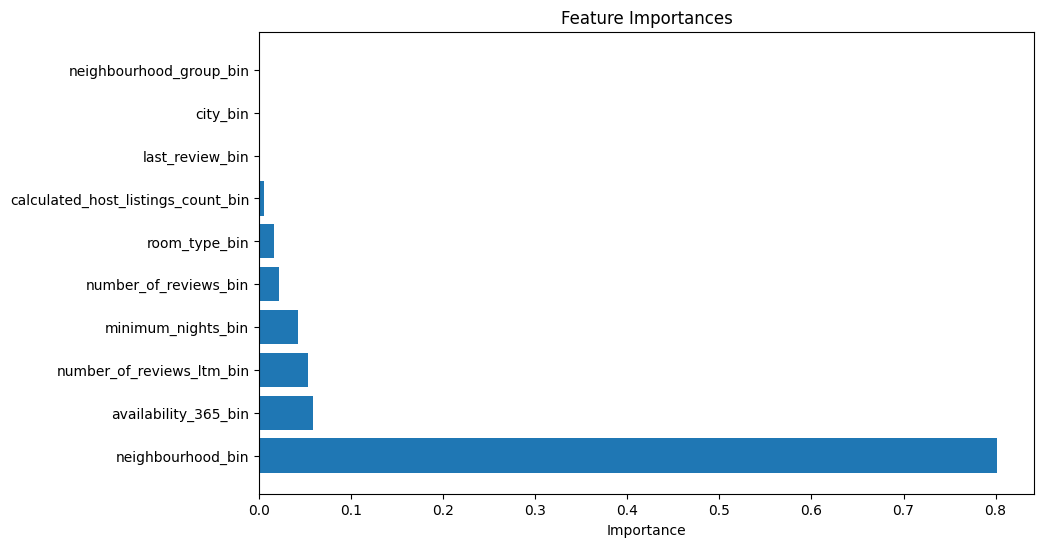

In [ ]:
# Plotting feature importance
importances = model_gbt.stages[-1].featureImportances

importance_values = importances.toArray()

feature_names = np.array(features)

feature_importances_dict = dict(zip(feature_names, importances))

sorted_feature_importances = sorted(feature_importances_dict.items(), key=lambda x: x[1], reverse=True)

sorted_features = [item[0] for item in sorted_feature_importances]
sorted_importances = [item[1] for item in sorted_feature_importances]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), sorted_importances, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()